In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import copy 
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

c:\Users\Onizea\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Onizea\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Onizea\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/fram

Seoul Bike Sharing Demand
Donated on 2/29/2020
The dataset contains count of public bicycles rented per hour in the Seoul Bike Sharing System, with corresponding weather data and holiday information

Dataset Characteristics
Multivariate

Subject Area
Business

Associated Tasks
Regression

Feature Type
Integer, Real

# Instances
8760

# Features
13
Source: https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [2]:
dataset_cols = ["bike_count","hour","temp","humidity","wind","visibility","dew_pt_temp","radiation","rain","snow","functional"]
df = pd.read_csv("data/SeoulBikeData.csv", encoding="cp949").drop(["Date","Holiday","Seasons"],axis=1)

In [3]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "Yes").astype(int)


In [4]:
df = df[df["hour"] == 12]
df = df.drop(["hour"],axis=1)

In [5]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


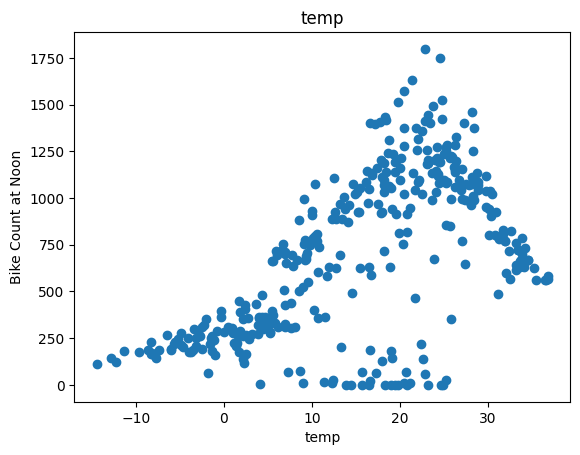

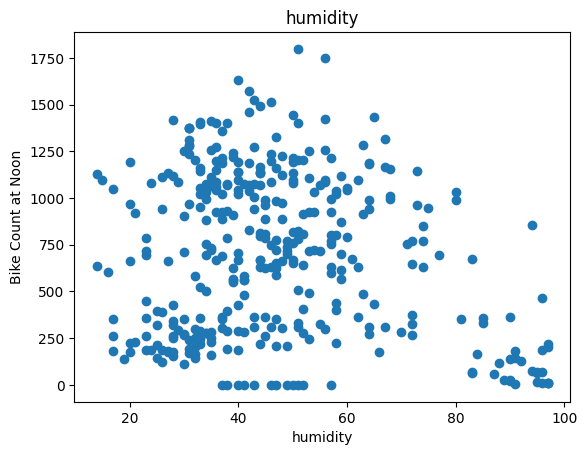

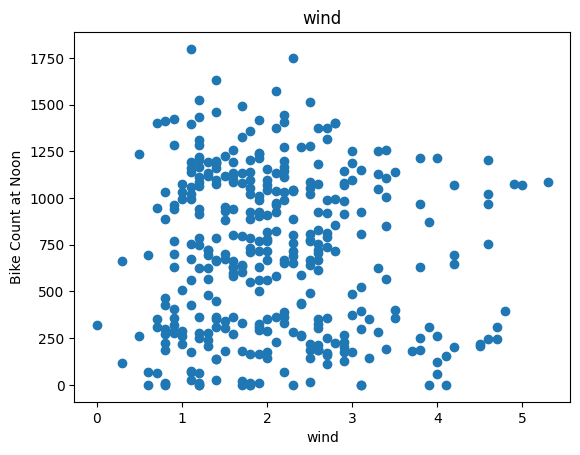

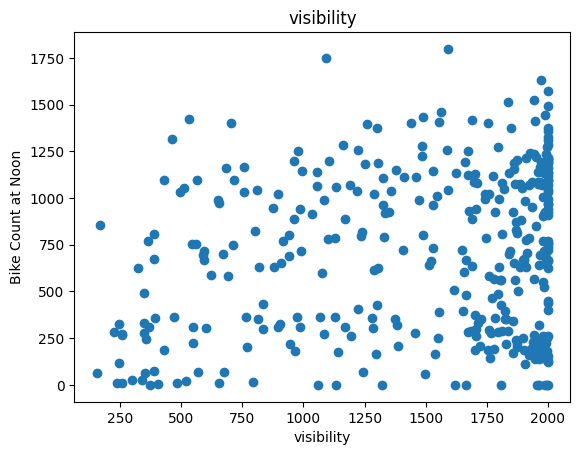

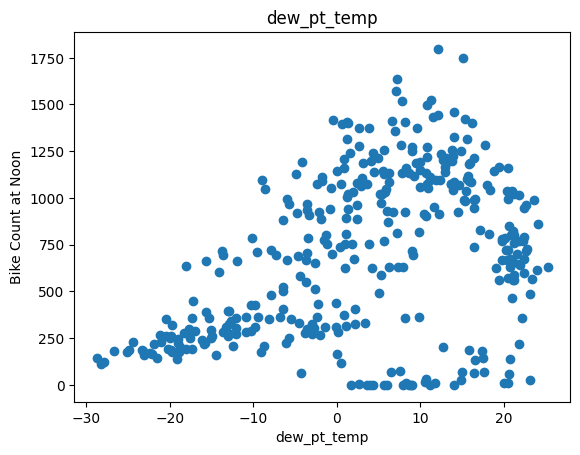

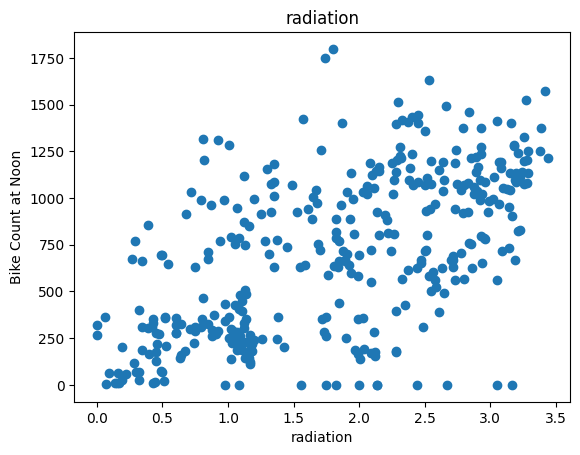

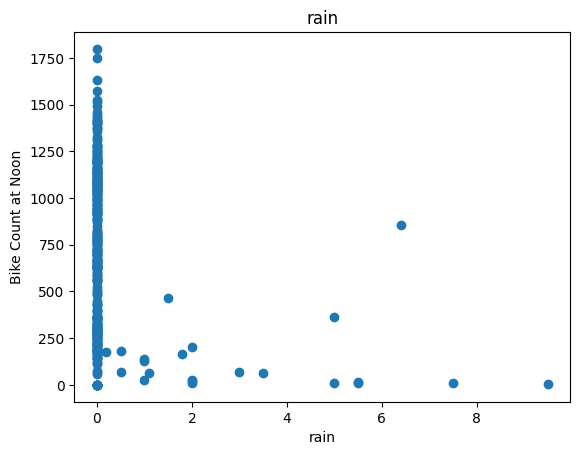

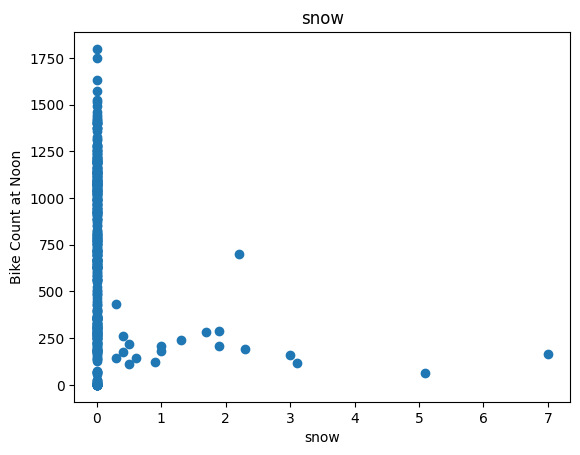

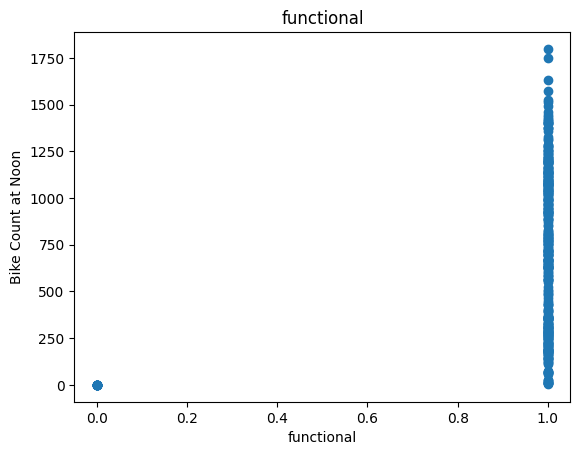

In [6]:
for label in df.columns[1:]:
    plt.scatter(df[label],df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()


In [7]:
df = df.drop(["wind","visibility","functional"],axis=1)

In [8]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


### Train/Valid/test Dataset

In [9]:
train, val , test = np.split(df.sample(frac=1),[int(0.6*len(df)), int(0.8*len(df))])

c:\Users\Onizea\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
def get_xy(dataframe,y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if  x_labels is None:
        X = dataframe[(c for c in dataframe.columns if c!=y_label)].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            X = dataframe[x_labels].values
    y = dataframe[y_label].values.reshape(-1 ,1)
    data = np.hstack((X,y))

    return data, X, y


In [11]:
_, X_train_temp, y_train_temp =get_xy(train,"bike_count", x_labels=['temp'])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=['temp'])
_, X_test_temp, y_test_temp = get_xy(test,"bike_count", x_labels=['temp'])

In [12]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [13]:
# print(temp_reg.coef_, temp_reg.intercept_)
temp_reg.score(X_test_temp ,y_test_temp)

0.4394648163259469

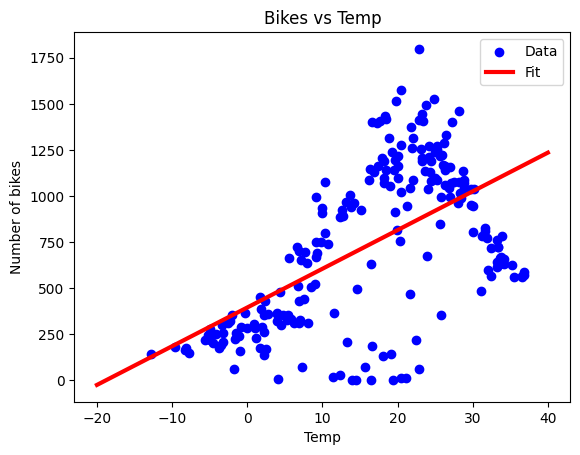

In [14]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

### Multiple Linear Regression

In [15]:
train, val , test = np.split(df.sample(frac=1),[int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

c:\Users\Onizea\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [16]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [17]:
all_reg.score(X_test_all, y_test_all)

0.44320465608307646

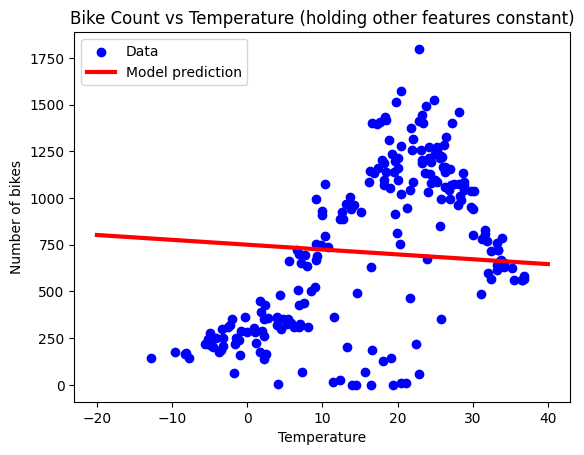

In [18]:
# Make a temperature range
x = np.linspace(-20, 40, 100)

# Create a matrix of mean feature values (shape = [100, 6])
X_plot = np.tile(X_train_all.mean(axis=0), (100, 1))

# Replace the temperature column with our range
temp_index = list(df.columns[1:]).index("temp")
X_plot[:, temp_index] = x

# Predict using the full model
y_pred = all_reg.predict(X_plot)

# Now plot
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
plt.plot(x, y_pred, label="Model prediction", color="red", linewidth=3)
plt.legend()
plt.title("Bike Count vs Temperature (holding other features constant)")
plt.ylabel("Number of bikes")
plt.xlabel("Temperature")
plt.show()

### Regression With Nueral NetWork

In [19]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

c:\Users\Onizea\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [22]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss="mean_squared_error")

In [23]:
history = temp_nn_model.fit(
    X_train_temp.reshape(-1), y_train_temp,
    epochs=1000,
    validation_data = (X_val_temp, y_val_temp)
)

Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 729788.0625 - val_loss: 598793.8125
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 728399.8750 - val_loss: 597620.8750
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 727054.0000 - val_loss: 596442.7500
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 725679.8750 - val_loss: 595271.5000
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 724324.1875 - val_loss: 594101.5000
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 722946.6875 - val_loss: 592949.0000
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 721643.3750 - val_loss: 591776.6875
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 720296.8125 - val_loss: 590611.5625
Epoch 9/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 718923.8125 - val_loss: 589463.5625
Epoch 10/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 717578.8750 - val_loss: 588319.2500
Epoch 11/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/st

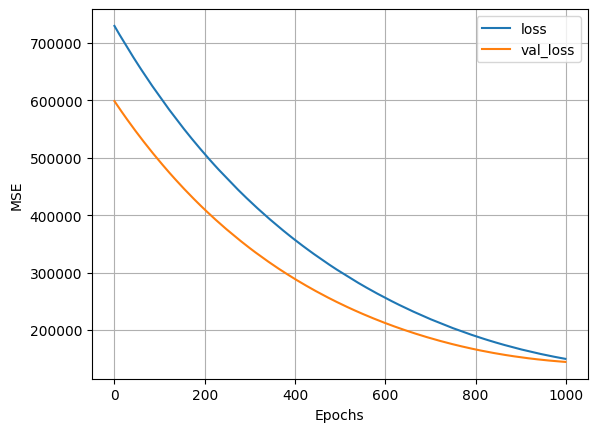

In [24]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


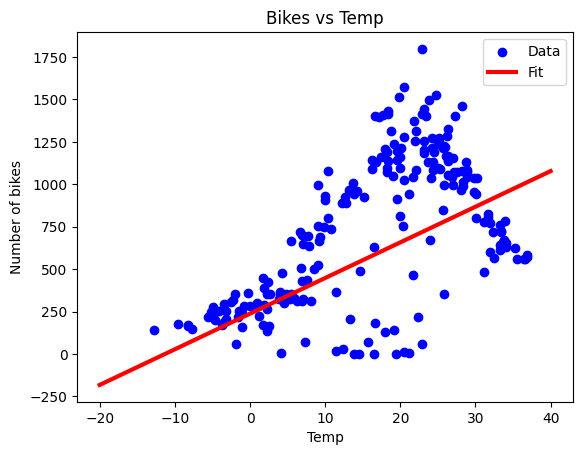

In [25]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)),
         label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

### Nueral Net

In [26]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

In [27]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp,y_val_temp),
    verbose=0,epochs=100
)

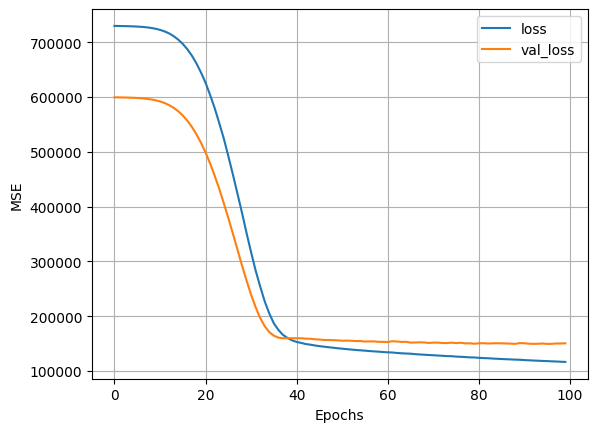

In [28]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


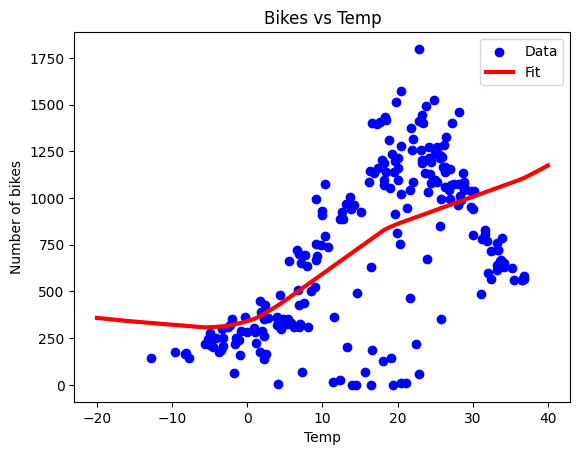

In [29]:
plt.scatter(X_train_temp, y_train_temp, label='Data', color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)),
         label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [30]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train_all)



In [31]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), loss="mean_squared_error")

In [32]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

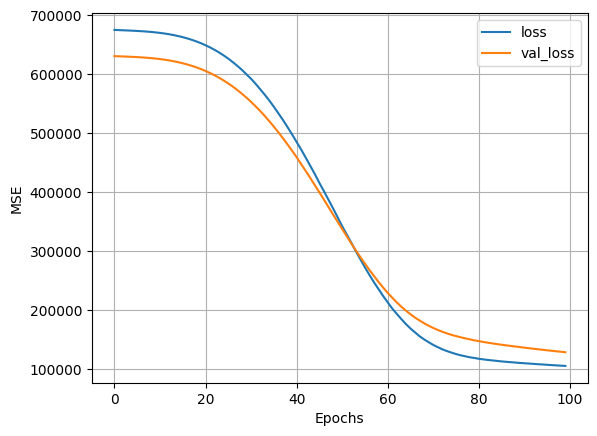

In [33]:
plot_loss(history)

In [34]:
# calculate the MSE for both linear regression and nueral net
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001BB2A2F2DE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [35]:
def MSE(y_pred, y_real):
    return np.mean(np.square(y_pred - y_real))

In [36]:
MSE(y_pred_lr,y_test_all)

np.float64(142708.55431514926)

In [37]:
MSE(y_pred_nn, y_test_all)

np.float64(170640.23102643213)

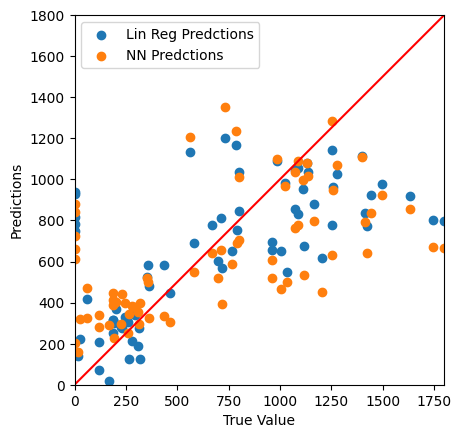

In [38]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Predctions")
plt.scatter(y_test_all, y_pred_nn, label="NN Predctions")
plt.xlabel("True Value")
plt.ylabel("Predictions")
lims = [0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ =plt.plot(lims,lims,c="red")